In [1]:
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import os
import random
import json
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import gc

In [2]:
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Define the autoencoder with increased complexity and regularization
def build_autoencoder(input_shape=(224, 224, 1)):
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.2)(x)
    
    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder

In [4]:
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,153 (5.07 MB)

 Trainable params: 1,329,153 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [6]:
# # Load images
# def load_images(image_dir, num_images=None):
#     image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
#     if num_images:
#         random.shuffle(image_paths)
#         image_paths = image_paths[:num_images]
#     images = [img_to_array(load_img(path, color_mode='grayscale', target_size=(224, 224))) / 255.0 for path in image_paths]
#     return np.array(images).reshape(len(images), 224, 224, 1), image_paths

In [7]:
# Load images function
def load_images(image_dir, num_images=None):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]
    if num_images:
        random.shuffle(image_paths)
        image_paths = image_paths[:num_images]
    images = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Ensure image size matches input shape
        img = img / 255.0  # Normalize to [0, 1]
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    return np.array(images), image_paths

In [8]:
# Load the specified number of images
num_normal_images = 9507
num_misbehavior_images = 787

In [9]:
# Load and preprocess the normal and misbehavior images
normal_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/data_side_lane/images"  
misbehavior_image_dir = "/Users/mohitkukreja/Desktop/TEA_Lab/blurry_images_cleaned/blurry_images_with_Walls/" 

# # Load images
# normal_images = load_images(normal_image_dir, 900)
# misbehavior_images = load_images(misbehavior_image_dir, 100)

# Load all images
# normal_images = load_images(normal_image_dir)
# misbehavior_images = load_images(misbehavior_image_dir)

# Load all images
normal_images, normal_image_paths = load_images(normal_image_dir)
misbehavior_images, misbehavior_image_paths = load_images(misbehavior_image_dir)


In [10]:
# Combine the images
images = np.concatenate((normal_images, misbehavior_images), axis=0)

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [12]:
images

array([[[[0.26666667],
         [0.27058824],
         [0.2745098 ],
         ...,
         [0.40784314],
         [0.34117647],
         [0.39215686]],

        [[0.2627451 ],
         [0.26666667],
         [0.2745098 ],
         ...,
         [0.42352941],
         [0.35294118],
         [0.37254902]],

        [[0.25882353],
         [0.2627451 ],
         [0.27058824],
         ...,
         [0.44313725],
         [0.38039216],
         [0.34901961]],

        ...,

        [[0.20784314],
         [0.20392157],
         [0.2       ],
         ...,
         [0.25882353],
         [0.34509804],
         [0.42745098]],

        [[0.20784314],
         [0.2       ],
         [0.19607843],
         ...,
         [0.25098039],
         [0.32941176],
         [0.40392157]],

        [[0.20392157],
         [0.2       ],
         [0.19607843],
         ...,
         [0.24705882],
         [0.32156863],
         [0.39215686]]],


       [[[0.25098039],
         [0.25098039],
         [0.25

In [13]:
# Training parameters
epochs = 20
batch_size = 64 

In [14]:
# Training loop with data augmentation

augmentation_batch_size = 100

subset_size = 1000  # Number of images per training subset

num_subsets = len(images) // subset_size

In [15]:
# Checkpoint callback
checkpoint = ModelCheckpoint('autoencoder_checkpoint.keras', save_best_only=True, monitor='loss', verbose=1)

In [16]:
# Calculate augmentation loss function
def calculate_augmentation_loss(autoencoder, normal_images, batch_size):
    sampled_indices = np.random.choice(len(normal_images), batch_size, replace=False)
    sampled_images = normal_images[sampled_indices]
    reconstructed_images = autoencoder.predict(sampled_images)
    augmentation_loss = np.mean(np.square(sampled_images - reconstructed_images))
    return augmentation_loss

In [17]:
# Training loop with data augmentation and subset processing
subset_size = 1000  # Number of images per training subset
num_subsets = len(images) // subset_size

for subset_index in range(num_subsets):
    subset_images = images[subset_index * subset_size: (subset_index + 1) * subset_size]
    np.random.shuffle(subset_images)
    
    for epoch in range(epochs):
        num_batches = len(subset_images) // batch_size
        total_loss = 0
        
        for i in tqdm(range(num_batches)):
            batch = subset_images[i * batch_size: (i + 1) * batch_size]
            augmented_batch = next(datagen.flow(batch, batch_size=batch_size))
            history = autoencoder.fit(augmented_batch, batch, epochs=1, batch_size=batch_size, shuffle=True, verbose=0)
            batch_loss = history.history['loss'][0]
            augmentation_loss = calculate_augmentation_loss(autoencoder, normal_images, augmentation_batch_size)
            total_loss += batch_loss + augmentation_loss
        
        avg_loss = total_loss / num_batches
        print(f'Subset {subset_index + 1}/{num_subsets}, Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}')
        
        # Save the model after each epoch
        autoencoder.save(f'autoencoder_epoch_{epoch+1}_subset_{subset_index+1}.h5')

        # Garbage collection to free up memory
        gc.collect()

  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


  7%|▋         | 1/15 [00:10<02:33, 10.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 13%|█▎        | 2/15 [00:20<02:09,  9.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 20%|██        | 3/15 [00:29<01:53,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 27%|██▋       | 4/15 [00:38<01:42,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 40%|████      | 6/15 [00:57<01:24,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


 47%|████▋     | 7/15 [01:06<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 73%|███████▎  | 11/15 [01:43<00:36,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


100%|██████████| 15/15 [02:19<00:00,  9.31s/it]


Subset 1/10, Epoch 1/20, Avg Loss: 0.7161


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


  7%|▋         | 1/15 [00:08<02:05,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 20%|██        | 3/15 [00:26<01:46,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 27%|██▋       | 4/15 [00:35<01:35,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 40%|████      | 6/15 [00:52<01:18,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 80%|████████  | 12/15 [01:44<00:26,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


100%|██████████| 15/15 [02:11<00:00,  8.73s/it]


Subset 1/10, Epoch 2/20, Avg Loss: 0.7101


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 20%|██        | 3/15 [00:26<01:44,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 33%|███▎      | 5/15 [00:43<01:25,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 40%|████      | 6/15 [00:52<01:19,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


100%|██████████| 15/15 [02:11<00:00,  8.75s/it]


Subset 1/10, Epoch 3/20, Avg Loss: 0.6979


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


  7%|▋         | 1/15 [00:08<01:59,  8.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:26<01:44,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 27%|██▋       | 4/15 [00:34<01:36,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 40%|████      | 6/15 [00:52<01:18,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 60%|██████    | 9/15 [01:18<00:51,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:09<00:00,  8.66s/it]


Subset 1/10, Epoch 4/20, Avg Loss: 0.6984


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


  7%|▋         | 1/15 [00:08<02:00,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 20%|██        | 3/15 [00:25<01:42,  8.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:34<01:33,  8.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 33%|███▎      | 5/15 [00:42<01:25,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 40%|████      | 6/15 [00:51<01:17,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 53%|█████▎    | 8/15 [01:08<01:00,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 73%|███████▎  | 11/15 [01:34<00:34,  8.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]


Subset 1/10, Epoch 5/20, Avg Loss: 0.6986


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 20%|██        | 3/15 [00:25<01:43,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 40%|████      | 6/15 [00:52<01:18,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]


Subset 1/10, Epoch 6/20, Avg Loss: 0.6959


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 20%|██        | 3/15 [00:25<01:43,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 33%|███▎      | 5/15 [00:43<01:25,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:51<01:16,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 53%|█████▎    | 8/15 [01:08<00:59,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 67%|██████▋   | 10/15 [01:25<00:42,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 73%|███████▎  | 11/15 [01:34<00:34,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 80%|████████  | 12/15 [01:43<00:26,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 87%|████████▋ | 13/15 [01:51<00:17,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 93%|█████████▎| 14/15 [02:00<00:08,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 769ms/step


100%|██████████| 15/15 [02:09<00:00,  8.63s/it]


Subset 1/10, Epoch 7/20, Avg Loss: 0.6936


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:26<01:47,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 40%|████      | 6/15 [00:53<01:18,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 53%|█████▎    | 8/15 [01:10<01:00,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:19<00:52,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 80%|████████  | 12/15 [01:44<00:25,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


100%|██████████| 15/15 [02:10<00:00,  8.68s/it]


Subset 1/10, Epoch 8/20, Avg Loss: 0.6914


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 20%|██        | 3/15 [00:25<01:42,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 27%|██▋       | 4/15 [00:34<01:33,  8.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 33%|███▎      | 5/15 [00:42<01:24,  8.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 40%|████      | 6/15 [00:51<01:16,  8.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 47%|████▋     | 7/15 [00:59<01:07,  8.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 53%|█████▎    | 8/15 [01:07<00:58,  8.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 60%|██████    | 9/15 [01:16<00:50,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 67%|██████▋   | 10/15 [01:24<00:42,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 73%|███████▎  | 11/15 [01:33<00:33,  8.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 80%|████████  | 12/15 [01:41<00:25,  8.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 87%|████████▋ | 13/15 [01:50<00:16,  8.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 93%|█████████▎| 14/15 [01:58<00:08,  8.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


100%|██████████| 15/15 [02:06<00:00,  8.46s/it]


Subset 1/10, Epoch 9/20, Avg Loss: 0.6909


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 20%|██        | 3/15 [00:26<01:45,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 40%|████      | 6/15 [00:52<01:18,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 80%|████████  | 12/15 [01:44<00:25,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


100%|██████████| 15/15 [02:12<00:00,  8.82s/it]


Subset 1/10, Epoch 10/20, Avg Loss: 0.6892


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:27<01:50,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 33%|███▎      | 5/15 [00:45<01:29,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 40%|████      | 6/15 [00:54<01:20,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 93%|█████████▎| 14/15 [02:06<00:09,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


100%|██████████| 15/15 [02:14<00:00,  9.00s/it]


Subset 1/10, Epoch 11/20, Avg Loss: 0.6881


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


  7%|▋         | 1/15 [00:08<02:00,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 20%|██        | 3/15 [00:25<01:43,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 40%|████      | 6/15 [00:51<01:17,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 53%|█████▎    | 8/15 [01:08<00:59,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 67%|██████▋   | 10/15 [01:25<00:42,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 73%|███████▎  | 11/15 [01:34<00:34,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 80%|████████  | 12/15 [01:43<00:26,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 93%|█████████▎| 14/15 [02:00<00:08,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


100%|██████████| 15/15 [02:09<00:00,  8.61s/it]


Subset 1/10, Epoch 12/20, Avg Loss: 0.6863


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


  7%|▋         | 1/15 [00:08<02:05,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 20%|██        | 3/15 [00:26<01:47,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 40%|████      | 6/15 [00:52<01:18,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


100%|██████████| 15/15 [02:10<00:00,  8.73s/it]


Subset 1/10, Epoch 13/20, Avg Loss: 0.6855


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 20%|██        | 3/15 [00:26<01:45,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 40%|████      | 6/15 [00:52<01:17,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]


Subset 1/10, Epoch 14/20, Avg Loss: 0.6864


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:18<01:57,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 40%|████      | 6/15 [00:52<01:17,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:27<00:44,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:11<00:00,  8.77s/it]


Subset 1/10, Epoch 15/20, Avg Loss: 0.6859


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:26<01:46,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step


 27%|██▋       | 4/15 [00:37<01:48,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 33%|███▎      | 5/15 [00:47<01:37,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 40%|████      | 6/15 [00:56<01:26,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:21<00:00,  9.45s/it]


Subset 1/10, Epoch 16/20, Avg Loss: 0.6844


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 20%|██        | 3/15 [00:27<01:50,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 40%|████      | 6/15 [00:56<01:26,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 67%|██████▋   | 10/15 [01:33<00:45,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 87%|████████▋ | 13/15 [01:59<00:17,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 93%|█████████▎| 14/15 [02:08<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


100%|██████████| 15/15 [02:17<00:00,  9.17s/it]


Subset 1/10, Epoch 17/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:26<01:45,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:52<01:19,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 80%|████████  | 12/15 [01:46<00:27,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [01:55<00:18,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


100%|██████████| 15/15 [02:12<00:00,  8.85s/it]


Subset 1/10, Epoch 18/20, Avg Loss: 0.6841


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 20%|██        | 3/15 [00:26<01:44,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 40%|████      | 6/15 [00:52<01:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 67%|██████▋   | 10/15 [01:27<00:44,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


100%|██████████| 15/15 [02:12<00:00,  8.83s/it]


Subset 1/10, Epoch 19/20, Avg Loss: 0.6838


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 20%|██        | 3/15 [00:27<01:50,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 40%|████      | 6/15 [00:54<01:20,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


100%|██████████| 15/15 [02:14<00:00,  8.96s/it]


Subset 1/10, Epoch 20/20, Avg Loss: 0.6841


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 20%|██        | 3/15 [00:26<01:43,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 40%|████      | 6/15 [00:51<01:17,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:08<01:00,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 60%|██████    | 9/15 [01:17<00:52,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 80%|████████  | 12/15 [01:44<00:26,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


100%|██████████| 15/15 [02:10<00:00,  8.71s/it]


Subset 2/10, Epoch 1/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 20%|██        | 3/15 [00:25<01:43,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:51<01:17,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 53%|█████▎    | 8/15 [01:08<00:59,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 67%|██████▋   | 10/15 [01:25<00:42,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 73%|███████▎  | 11/15 [01:34<00:34,  8.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 87%|████████▋ | 13/15 [01:51<00:17,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 93%|█████████▎| 14/15 [02:00<00:08,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]


Subset 2/10, Epoch 2/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 20%|██        | 3/15 [00:27<01:50,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 40%|████      | 6/15 [00:55<01:21,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 60%|██████    | 9/15 [01:21<00:52,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 67%|██████▋   | 10/15 [01:29<00:43,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 73%|███████▎  | 11/15 [01:38<00:34,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


100%|██████████| 15/15 [02:14<00:00,  8.99s/it]


Subset 2/10, Epoch 3/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 20%|██        | 3/15 [00:26<01:45,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 40%|████      | 6/15 [00:52<01:18,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 80%|████████  | 12/15 [01:44<00:25,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


100%|██████████| 15/15 [02:10<00:00,  8.70s/it]


Subset 2/10, Epoch 4/20, Avg Loss: 0.6838


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 20%|██        | 3/15 [00:26<01:45,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 40%|████      | 6/15 [00:52<01:18,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:19<00:52,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:04<00:09,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


100%|██████████| 15/15 [02:12<00:00,  8.86s/it]


Subset 2/10, Epoch 5/20, Avg Loss: 0.6832


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


  7%|▋         | 1/15 [00:09<02:07,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 20%|██        | 3/15 [00:26<01:46,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 40%|████      | 6/15 [00:53<01:20,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 47%|████▋     | 7/15 [01:02<01:10,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 60%|██████    | 9/15 [01:19<00:52,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 67%|██████▋   | 10/15 [01:28<00:43,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


100%|██████████| 15/15 [02:11<00:00,  8.79s/it]


Subset 2/10, Epoch 6/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 20%|██        | 3/15 [00:26<01:44,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 40%|████      | 6/15 [00:52<01:19,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 80%|████████  | 12/15 [01:44<00:25,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


100%|██████████| 15/15 [02:10<00:00,  8.71s/it]


Subset 2/10, Epoch 7/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 20%|██        | 3/15 [00:26<01:46,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 40%|████      | 6/15 [00:53<01:19,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 80%|████████  | 12/15 [01:46<00:26,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:12<00:00,  8.83s/it]


Subset 2/10, Epoch 8/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 20%|██        | 3/15 [00:26<01:44,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 40%|████      | 6/15 [00:52<01:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:02<01:12,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


100%|██████████| 15/15 [02:11<00:00,  8.76s/it]


Subset 2/10, Epoch 9/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 20%|██        | 3/15 [00:26<01:44,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 40%|████      | 6/15 [00:51<01:17,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


100%|██████████| 15/15 [02:10<00:00,  8.69s/it]


Subset 2/10, Epoch 10/20, Avg Loss: 0.6841


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 20%|██        | 3/15 [00:26<01:44,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 40%|████      | 6/15 [00:51<01:17,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 47%|████▋     | 7/15 [01:00<01:08,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 93%|█████████▎| 14/15 [02:01<00:08,  8.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:09<00:00,  8.65s/it]


Subset 2/10, Epoch 11/20, Avg Loss: 0.6836


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


  7%|▋         | 1/15 [00:08<01:57,  8.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 13%|█▎        | 2/15 [00:16<01:50,  8.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 20%|██        | 3/15 [00:25<01:42,  8.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 27%|██▋       | 4/15 [00:34<01:33,  8.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 33%|███▎      | 5/15 [00:42<01:25,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 40%|████      | 6/15 [00:51<01:17,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [00:59<01:08,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 53%|█████▎    | 8/15 [01:08<01:00,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 60%|██████    | 9/15 [01:17<00:51,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 67%|██████▋   | 10/15 [01:25<00:42,  8.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 73%|███████▎  | 11/15 [01:34<00:34,  8.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 80%|████████  | 12/15 [01:42<00:25,  8.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 87%|████████▋ | 13/15 [01:51<00:17,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 93%|█████████▎| 14/15 [02:00<00:08,  8.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


100%|██████████| 15/15 [02:09<00:00,  8.62s/it]


Subset 2/10, Epoch 12/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:26<01:46,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 40%|████      | 6/15 [00:52<01:18,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 53%|█████▎    | 8/15 [01:10<01:00,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


100%|██████████| 15/15 [02:11<00:00,  8.75s/it]


Subset 2/10, Epoch 13/20, Avg Loss: 0.6835


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


  7%|▋         | 1/15 [00:08<02:01,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 13%|█▎        | 2/15 [00:17<01:51,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 20%|██        | 3/15 [00:25<01:43,  8.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 27%|██▋       | 4/15 [00:34<01:34,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 40%|████      | 6/15 [00:51<01:18,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:09<01:01,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 60%|██████    | 9/15 [01:17<00:52,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 67%|██████▋   | 10/15 [01:26<00:43,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 80%|████████  | 12/15 [01:43<00:25,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 87%|████████▋ | 13/15 [01:52<00:17,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 93%|█████████▎| 14/15 [02:00<00:08,  8.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


100%|██████████| 15/15 [02:09<00:00,  8.64s/it]


Subset 2/10, Epoch 14/20, Avg Loss: 0.6837


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 20%|██        | 3/15 [00:26<01:47,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 40%|████      | 6/15 [00:53<01:19,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 60%|██████    | 9/15 [01:20<00:54,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


 73%|███████▎  | 11/15 [01:42<00:41, 10.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 777ms/step


 80%|████████  | 12/15 [01:53<00:32, 10.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 893ms/step


 87%|████████▋ | 13/15 [02:04<00:21, 10.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step


 93%|█████████▎| 14/15 [02:16<00:10, 10.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:25<00:00,  9.70s/it]


Subset 2/10, Epoch 15/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


  7%|▋         | 1/15 [00:09<02:19,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 20%|██        | 3/15 [00:28<01:54,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 27%|██▋       | 4/15 [00:38<01:43,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:56<01:25,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 2/10, Epoch 16/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 936ms/step


 20%|██        | 3/15 [00:28<01:54,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 27%|██▋       | 4/15 [00:37<01:44,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


100%|██████████| 15/15 [02:17<00:00,  9.17s/it]


Subset 2/10, Epoch 17/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 20%|██        | 3/15 [00:26<01:44,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 40%|████      | 6/15 [00:53<01:19,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


100%|██████████| 15/15 [02:11<00:00,  8.77s/it]


Subset 2/10, Epoch 18/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 40%|████      | 6/15 [00:53<01:19,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 47%|████▋     | 7/15 [01:02<01:10,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:11<01:01,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 80%|████████  | 12/15 [01:46<00:26,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 87%|████████▋ | 13/15 [01:56<00:18,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


100%|██████████| 15/15 [02:13<00:00,  8.90s/it]


Subset 2/10, Epoch 19/20, Avg Loss: 0.6832


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 40%|████      | 6/15 [00:52<01:18,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 80%|████████  | 12/15 [01:46<00:26,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


100%|██████████| 15/15 [02:13<00:00,  8.90s/it]


Subset 2/10, Epoch 20/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 20%|██        | 3/15 [00:26<01:46,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 40%|████      | 6/15 [00:52<01:19,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:36<00:34,  8.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 80%|████████  | 12/15 [01:44<00:26,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


100%|██████████| 15/15 [02:10<00:00,  8.72s/it]


Subset 3/10, Epoch 1/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 20%|██        | 3/15 [00:28<01:53,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 40%|████      | 6/15 [00:55<01:21,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 47%|████▋     | 7/15 [01:03<01:11,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


100%|██████████| 15/15 [02:14<00:00,  8.98s/it]


Subset 3/10, Epoch 2/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step


  7%|▋         | 1/15 [00:11<02:35, 11.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step


 13%|█▎        | 2/15 [00:21<02:17, 10.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step


 20%|██        | 3/15 [00:31<02:05, 10.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step


 27%|██▋       | 4/15 [00:41<01:53, 10.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 760ms/step


 33%|███▎      | 5/15 [00:52<01:43, 10.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step


 40%|████      | 6/15 [01:02<01:33, 10.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step


 47%|████▋     | 7/15 [01:13<01:23, 10.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step


 53%|█████▎    | 8/15 [01:23<01:13, 10.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step


 60%|██████    | 9/15 [01:34<01:02, 10.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 761ms/step


 67%|██████▋   | 10/15 [01:44<00:52, 10.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 73%|███████▎  | 11/15 [01:53<00:40, 10.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 80%|████████  | 12/15 [02:02<00:29,  9.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 87%|████████▋ | 13/15 [02:11<00:18,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 93%|█████████▎| 14/15 [02:20<00:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


100%|██████████| 15/15 [02:29<00:00,  9.94s/it]


Subset 3/10, Epoch 3/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 20%|██        | 3/15 [00:26<01:46,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step


 33%|███▎      | 5/15 [00:46<01:34,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 40%|████      | 6/15 [00:56<01:27,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 80%|████████  | 12/15 [01:49<00:26,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 87%|████████▋ | 13/15 [01:58<00:17,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


100%|██████████| 15/15 [02:15<00:00,  9.04s/it]


Subset 3/10, Epoch 4/20, Avg Loss: 0.6842


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 20%|██        | 3/15 [00:26<01:45,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 40%|████      | 6/15 [00:52<01:18,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 47%|████▋     | 7/15 [01:01<01:09,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:09<01:00,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 60%|██████    | 9/15 [01:18<00:52,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 67%|██████▋   | 10/15 [01:27<00:43,  8.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 73%|███████▎  | 11/15 [01:35<00:34,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step


 80%|████████  | 12/15 [01:44<00:26,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 87%|████████▋ | 13/15 [01:53<00:17,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 93%|█████████▎| 14/15 [02:02<00:08,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


100%|██████████| 15/15 [02:11<00:00,  8.76s/it]


Subset 3/10, Epoch 5/20, Avg Loss: 0.6835


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 13%|█▎        | 2/15 [00:17<01:52,  8.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 20%|██        | 3/15 [00:26<01:44,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 27%|██▋       | 4/15 [00:34<01:35,  8.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 33%|███▎      | 5/15 [00:43<01:26,  8.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 40%|████      | 6/15 [00:52<01:18,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 47%|████▋     | 7/15 [01:00<01:09,  8.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:09<01:01,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 60%|██████    | 9/15 [01:19<00:53,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 67%|██████▋   | 10/15 [01:28<00:45,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


100%|██████████| 15/15 [02:12<00:00,  8.83s/it]


Subset 3/10, Epoch 6/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step


 20%|██        | 3/15 [00:27<01:49,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 40%|████      | 6/15 [00:54<01:23,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


100%|██████████| 15/15 [02:16<00:00,  9.08s/it]


Subset 3/10, Epoch 7/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 20%|██        | 3/15 [00:26<01:47,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 40%|████      | 6/15 [00:53<01:19,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 80%|████████  | 12/15 [01:47<00:27,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 87%|████████▋ | 13/15 [01:57<00:18,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 93%|█████████▎| 14/15 [02:05<00:09,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step


100%|██████████| 15/15 [02:15<00:00,  9.02s/it]


Subset 3/10, Epoch 8/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 20%|██        | 3/15 [00:27<01:48,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 33%|███▎      | 5/15 [00:45<01:29,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 40%|████      | 6/15 [00:54<01:20,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


100%|██████████| 15/15 [02:14<00:00,  8.95s/it]


Subset 3/10, Epoch 9/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:35<01:39,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 33%|███▎      | 5/15 [00:44<01:30,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 40%|████      | 6/15 [00:53<01:20,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


100%|██████████| 15/15 [02:13<00:00,  8.91s/it]


Subset 3/10, Epoch 10/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 20%|██        | 3/15 [00:26<01:45,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 40%|████      | 6/15 [00:52<01:19,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 80%|████████  | 12/15 [01:46<00:27,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 87%|████████▋ | 13/15 [01:56<00:18,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 93%|█████████▎| 14/15 [02:05<00:09,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


100%|██████████| 15/15 [02:13<00:00,  8.93s/it]


Subset 3/10, Epoch 11/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 20%|██        | 3/15 [00:26<01:45,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 40%|████      | 6/15 [00:53<01:20,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step


 53%|█████▎    | 8/15 [01:11<01:03,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:20<00:54,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 67%|██████▋   | 10/15 [01:29<00:45,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 73%|███████▎  | 11/15 [01:38<00:36,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 80%|████████  | 12/15 [01:47<00:27,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 87%|████████▋ | 13/15 [01:56<00:18,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:14<00:00,  8.97s/it]


Subset 3/10, Epoch 12/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 20%|██        | 3/15 [00:27<01:51,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 40%|████      | 6/15 [00:54<01:20,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 73%|███████▎  | 11/15 [01:39<00:36,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 80%|████████  | 12/15 [01:48<00:27,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 87%|████████▋ | 13/15 [01:57<00:18,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 93%|█████████▎| 14/15 [02:06<00:09,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


100%|██████████| 15/15 [02:15<00:00,  9.03s/it]


Subset 3/10, Epoch 13/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 20%|██        | 3/15 [00:26<01:47,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 40%|████      | 6/15 [00:54<01:22,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 60%|██████    | 9/15 [01:21<00:54,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


100%|██████████| 15/15 [02:16<00:00,  9.11s/it]


Subset 3/10, Epoch 14/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 13%|█▎        | 2/15 [00:18<01:57,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 20%|██        | 3/15 [00:27<01:48,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 40%|████      | 6/15 [02:23<05:53, 39.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 47%|████▋     | 7/15 [02:32<03:56, 29.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step


 53%|█████▎    | 8/15 [02:42<02:42, 23.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 60%|██████    | 9/15 [02:51<01:53, 18.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 67%|██████▋   | 10/15 [03:01<01:19, 15.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step


 73%|███████▎  | 11/15 [03:11<00:56, 14.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 80%|████████  | 12/15 [03:21<00:38, 12.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step


 87%|████████▋ | 13/15 [03:30<00:23, 11.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 93%|█████████▎| 14/15 [03:40<00:11, 11.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


100%|██████████| 15/15 [03:48<00:00, 15.26s/it]


Subset 3/10, Epoch 15/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:27<01:49,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 781ms/step


 27%|██▋       | 4/15 [00:38<01:50, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 936ms/step


 33%|███▎      | 5/15 [00:50<01:47, 10.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 40%|████      | 6/15 [01:01<01:37, 10.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step


 47%|████▋     | 7/15 [01:12<01:27, 10.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step


 53%|█████▎    | 8/15 [01:23<01:15, 10.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step


 60%|██████    | 9/15 [01:33<01:04, 10.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 67%|██████▋   | 10/15 [01:43<00:52, 10.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 73%|███████▎  | 11/15 [01:53<00:40, 10.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 80%|████████  | 12/15 [02:02<00:29,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [02:12<00:19,  9.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 93%|█████████▎| 14/15 [02:22<00:09,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


100%|██████████| 15/15 [02:31<00:00, 10.11s/it]


Subset 3/10, Epoch 16/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step


 20%|██        | 3/15 [00:31<02:09, 10.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step


 27%|██▋       | 4/15 [00:42<02:00, 10.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


 33%|███▎      | 5/15 [00:54<01:51, 11.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 755ms/step


 40%|████      | 6/15 [01:06<01:43, 11.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step


 47%|████▋     | 7/15 [01:17<01:30, 11.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step


 53%|█████▎    | 8/15 [01:28<01:18, 11.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 770ms/step


 60%|██████    | 9/15 [01:39<01:06, 11.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 861ms/step


 67%|██████▋   | 10/15 [01:51<00:56, 11.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 817ms/step


 73%|███████▎  | 11/15 [02:03<00:46, 11.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 721ms/step


 80%|████████  | 12/15 [02:13<00:33, 11.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step


 87%|████████▋ | 13/15 [02:24<00:22, 11.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 773ms/step


 93%|█████████▎| 14/15 [02:34<00:10, 10.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step


100%|██████████| 15/15 [02:44<00:00, 10.97s/it]


Subset 3/10, Epoch 17/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 715ms/step


  7%|▋         | 1/15 [00:11<02:36, 11.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step


 13%|█▎        | 2/15 [00:21<02:16, 10.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 20%|██        | 3/15 [00:31<02:02, 10.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 27%|██▋       | 4/15 [00:40<01:50, 10.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 33%|███▎      | 5/15 [00:50<01:38,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


 40%|████      | 6/15 [01:00<01:28,  9.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 47%|████▋     | 7/15 [01:09<01:17,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 53%|█████▎    | 8/15 [01:18<01:06,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 60%|██████    | 9/15 [01:27<00:55,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 67%|██████▋   | 10/15 [01:36<00:45,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 73%|███████▎  | 11/15 [01:45<00:36,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 80%|████████  | 12/15 [01:54<00:27,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 87%|████████▋ | 13/15 [02:04<00:18,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


100%|██████████| 15/15 [02:22<00:00,  9.49s/it]


Subset 3/10, Epoch 18/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 20%|██        | 3/15 [00:26<01:46,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 40%|████      | 6/15 [00:53<01:21,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 47%|████▋     | 7/15 [01:02<01:12,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 73%|███████▎  | 11/15 [01:38<00:36,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 80%|████████  | 12/15 [01:47<00:27,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 87%|████████▋ | 13/15 [01:57<00:18,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


100%|██████████| 15/15 [02:17<00:00,  9.15s/it]


Subset 3/10, Epoch 19/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


  7%|▋         | 1/15 [00:10<02:28, 10.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 13%|█▎        | 2/15 [00:20<02:10, 10.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 20%|██        | 3/15 [00:29<01:58,  9.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step


 27%|██▋       | 4/15 [00:39<01:48,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 33%|███▎      | 5/15 [00:49<01:38,  9.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 40%|████      | 6/15 [00:59<01:28,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step


 47%|████▋     | 7/15 [01:09<01:19,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 53%|█████▎    | 8/15 [01:19<01:09,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 60%|██████    | 9/15 [01:28<00:57,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:37<00:46,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step


 73%|███████▎  | 11/15 [01:46<00:36,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 80%|████████  | 12/15 [01:54<00:27,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


100%|██████████| 15/15 [02:21<00:00,  9.45s/it]


Subset 3/10, Epoch 20/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


  7%|▋         | 1/15 [00:09<02:07,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 20%|██        | 3/15 [00:26<01:45,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step


 27%|██▋       | 4/15 [00:35<01:35,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:44<01:27,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 40%|████      | 6/15 [00:53<01:21,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 934ms/step


 53%|█████▎    | 8/15 [01:13<01:07,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 60%|██████    | 9/15 [01:24<01:00, 10.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 67%|██████▋   | 10/15 [01:33<00:48,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 73%|███████▎  | 11/15 [01:42<00:38,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


100%|██████████| 15/15 [02:19<00:00,  9.27s/it]


Subset 4/10, Epoch 1/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 20%|██        | 3/15 [00:27<01:49,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 33%|███▎      | 5/15 [00:45<01:29,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 40%|████      | 6/15 [00:54<01:20,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 47%|████▋     | 7/15 [01:03<01:11,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 80%|████████  | 12/15 [01:48<00:27,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


100%|██████████| 15/15 [02:16<00:00,  9.11s/it]


Subset 4/10, Epoch 2/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 20%|██        | 3/15 [00:26<01:46,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 40%|████      | 6/15 [00:53<01:20,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 73%|███████▎  | 11/15 [01:38<00:36,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 80%|████████  | 12/15 [01:47<00:27,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


100%|██████████| 15/15 [02:14<00:00,  8.95s/it]


Subset 4/10, Epoch 3/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 33%|███▎      | 5/15 [00:45<01:33,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 40%|████      | 6/15 [00:54<01:22,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:15<00:00,  9.01s/it]


Subset 4/10, Epoch 4/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 20%|██        | 3/15 [00:26<01:45,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 40%|████      | 6/15 [00:53<01:19,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 67%|██████▋   | 10/15 [01:29<00:45,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step


 73%|███████▎  | 11/15 [01:39<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 80%|████████  | 12/15 [01:48<00:27,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 87%|████████▋ | 13/15 [01:57<00:18,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step


 93%|█████████▎| 14/15 [02:06<00:09,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


100%|██████████| 15/15 [02:15<00:00,  9.04s/it]


Subset 4/10, Epoch 5/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 20%|██        | 3/15 [00:26<01:45,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 27%|██▋       | 4/15 [00:35<01:37,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 40%|████      | 6/15 [00:53<01:19,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:10<01:01,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 80%|████████  | 12/15 [01:46<00:26,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


100%|██████████| 15/15 [02:13<00:00,  8.90s/it]


Subset 4/10, Epoch 6/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 20%|██        | 3/15 [00:27<01:49,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 40%|████      | 6/15 [00:55<01:22,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


100%|██████████| 15/15 [02:14<00:00,  8.95s/it]


Subset 4/10, Epoch 7/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 13%|█▎        | 2/15 [00:17<01:53,  8.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 20%|██        | 3/15 [00:26<01:48,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 27%|██▋       | 4/15 [00:35<01:39,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 40%|████      | 6/15 [00:54<01:21,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 47%|████▋     | 7/15 [01:02<01:11,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 73%|███████▎  | 11/15 [01:40<00:37,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


100%|██████████| 15/15 [02:16<00:00,  9.07s/it]


Subset 4/10, Epoch 8/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 20%|██        | 3/15 [00:26<01:44,  8.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 27%|██▋       | 4/15 [00:34<01:36,  8.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 33%|███▎      | 5/15 [00:43<01:27,  8.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 40%|████      | 6/15 [00:52<01:18,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 73%|███████▎  | 11/15 [01:36<00:35,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 80%|████████  | 12/15 [01:45<00:26,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 87%|████████▋ | 13/15 [01:54<00:17,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


100%|██████████| 15/15 [02:11<00:00,  8.79s/it]


Subset 4/10, Epoch 9/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 20%|██        | 3/15 [00:26<01:46,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 33%|███▎      | 5/15 [00:45<01:32,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 40%|████      | 6/15 [00:54<01:23,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 60%|██████    | 9/15 [01:21<00:54,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


100%|██████████| 15/15 [02:15<00:00,  9.01s/it]


Subset 4/10, Epoch 10/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 20%|██        | 3/15 [00:26<01:46,  8.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 40%|████      | 6/15 [00:53<01:19,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 47%|████▋     | 7/15 [01:01<01:10,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 60%|██████    | 9/15 [01:19<00:53,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 80%|████████  | 12/15 [01:47<00:27,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 93%|█████████▎| 14/15 [02:04<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


100%|██████████| 15/15 [02:13<00:00,  8.92s/it]


Subset 4/10, Epoch 11/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 20%|██        | 3/15 [00:27<01:48,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 40%|████      | 6/15 [00:54<01:21,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 732ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 67%|██████▋   | 10/15 [01:38<00:57, 11.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 73%|███████▎  | 11/15 [01:48<00:43, 10.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 80%|████████  | 12/15 [01:58<00:32, 10.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [02:08<00:20, 10.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 93%|█████████▎| 14/15 [02:17<00:09,  9.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:26<00:00,  9.76s/it]


Subset 4/10, Epoch 12/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:27<01:49,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 40%|████      | 6/15 [00:54<01:21,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 862ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 4/10, Epoch 13/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step


  7%|▋         | 1/15 [00:09<02:17,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step


 13%|█▎        | 2/15 [00:19<02:10, 10.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step


 20%|██        | 3/15 [00:29<01:59,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step


 27%|██▋       | 4/15 [00:39<01:48,  9.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step


 33%|███▎      | 5/15 [00:49<01:39,  9.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step


 40%|████      | 6/15 [00:59<01:29,  9.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step


 47%|████▋     | 7/15 [01:09<01:18,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step


 53%|█████▎    | 8/15 [01:19<01:08,  9.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step


 60%|██████    | 9/15 [01:28<00:59,  9.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step


 67%|██████▋   | 10/15 [01:38<00:48,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step


 73%|███████▎  | 11/15 [01:48<00:39,  9.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step


 80%|████████  | 12/15 [01:58<00:29,  9.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 87%|████████▋ | 13/15 [02:07<00:19,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 93%|█████████▎| 14/15 [02:17<00:09,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


100%|██████████| 15/15 [02:26<00:00,  9.75s/it]


Subset 4/10, Epoch 14/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step


 20%|██        | 3/15 [00:27<01:50,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 40%|████      | 6/15 [00:55<01:22,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


100%|██████████| 15/15 [02:14<00:00,  8.99s/it]


Subset 4/10, Epoch 15/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:26<01:46,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 27%|██▋       | 4/15 [00:35<01:36,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 40%|████      | 6/15 [00:53<01:19,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:10<01:02,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 60%|██████    | 9/15 [01:20<00:55,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 67%|██████▋   | 10/15 [01:29<00:45,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 73%|███████▎  | 11/15 [01:38<00:35,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 93%|█████████▎| 14/15 [02:05<00:09,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


100%|██████████| 15/15 [02:14<00:00,  8.94s/it]


Subset 4/10, Epoch 16/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 20%|██        | 3/15 [00:26<01:48,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 40%|████      | 6/15 [00:53<01:20,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 53%|█████▎    | 8/15 [01:11<01:01,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 60%|██████    | 9/15 [01:20<00:54,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 67%|██████▋   | 10/15 [01:29<00:45,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 73%|███████▎  | 11/15 [01:38<00:36,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step


 93%|█████████▎| 14/15 [02:06<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


100%|██████████| 15/15 [02:15<00:00,  9.03s/it]


Subset 4/10, Epoch 17/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 20%|██        | 3/15 [00:26<01:46,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 40%|████      | 6/15 [00:53<01:20,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 67%|██████▋   | 10/15 [01:29<00:44,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 73%|███████▎  | 11/15 [01:38<00:36,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 80%|████████  | 12/15 [01:47<00:26,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 87%|████████▋ | 13/15 [01:56<00:17,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:05<00:08,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


100%|██████████| 15/15 [02:13<00:00,  8.93s/it]


Subset 4/10, Epoch 18/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


  7%|▋         | 1/15 [00:08<02:02,  8.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 20%|██        | 3/15 [00:26<01:48,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 27%|██▋       | 4/15 [00:35<01:39,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:53<01:20,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 47%|████▋     | 7/15 [01:02<01:10,  8.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 53%|█████▎    | 8/15 [01:11<01:01,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 60%|██████    | 9/15 [01:20<00:53,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 67%|██████▋   | 10/15 [01:28<00:44,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 73%|███████▎  | 11/15 [01:37<00:35,  8.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 80%|████████  | 12/15 [01:46<00:26,  8.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 87%|████████▋ | 13/15 [01:55<00:17,  8.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 93%|█████████▎| 14/15 [02:03<00:08,  8.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


100%|██████████| 15/15 [02:12<00:00,  8.85s/it]


Subset 4/10, Epoch 19/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


  7%|▋         | 1/15 [00:10<02:21, 10.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 20%|██        | 3/15 [00:28<01:50,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 27%|██▋       | 4/15 [00:37<01:40,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 40%|████      | 6/15 [00:55<01:21,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 60%|██████    | 9/15 [01:21<00:53,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 67%|██████▋   | 10/15 [01:30<00:44,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  8.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 80%|████████  | 12/15 [01:48<00:26,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:06<00:09,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


100%|██████████| 15/15 [02:15<00:00,  9.04s/it]


Subset 4/10, Epoch 20/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 20%|██        | 3/15 [00:27<01:47,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 33%|███▎      | 5/15 [00:44<01:28,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 40%|████      | 6/15 [00:54<01:22,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 53%|█████▎    | 8/15 [01:12<01:04,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 60%|██████    | 9/15 [01:21<00:54,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 73%|███████▎  | 11/15 [01:39<00:35,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 80%|████████  | 12/15 [01:48<00:27,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 87%|████████▋ | 13/15 [01:57<00:17,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


100%|██████████| 15/15 [02:15<00:00,  9.03s/it]


Subset 5/10, Epoch 1/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 13%|█▎        | 2/15 [00:18<01:57,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 20%|██        | 3/15 [00:27<01:48,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 27%|██▋       | 4/15 [00:36<01:38,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step


 40%|████      | 6/15 [00:53<01:20,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 47%|████▋     | 7/15 [01:02<01:11,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 53%|█████▎    | 8/15 [01:11<01:02,  8.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 60%|██████    | 9/15 [01:22<00:56,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 67%|██████▋   | 10/15 [01:31<00:46,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 73%|███████▎  | 11/15 [01:40<00:37,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


 93%|█████████▎| 14/15 [02:07<00:08,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


100%|██████████| 15/15 [02:15<00:00,  9.07s/it]


Subset 5/10, Epoch 2/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


  7%|▋         | 1/15 [00:08<02:03,  8.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 20%|██        | 3/15 [00:27<01:48,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 40%|████      | 6/15 [00:54<01:21,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 47%|████▋     | 7/15 [01:03<01:11,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:12<01:02,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 60%|██████    | 9/15 [01:21<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step


 67%|██████▋   | 10/15 [01:31<00:47,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 73%|███████▎  | 11/15 [01:41<00:38,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 80%|████████  | 12/15 [01:50<00:28,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 848ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 5/10, Epoch 3/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 895ms/step


  7%|▋         | 1/15 [00:11<02:40, 11.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step


 13%|█▎        | 2/15 [00:22<02:22, 10.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 857ms/step


 20%|██        | 3/15 [00:34<02:20, 11.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 27%|██▋       | 4/15 [00:46<02:09, 11.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 33%|███▎      | 5/15 [00:56<01:49, 10.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 40%|████      | 6/15 [01:05<01:32, 10.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 47%|████▋     | 7/15 [01:13<01:18,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 53%|█████▎    | 8/15 [01:22<01:06,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 60%|██████    | 9/15 [01:31<00:55,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step


 67%|██████▋   | 10/15 [01:40<00:45,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step


 73%|███████▎  | 11/15 [01:48<00:35,  8.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 80%|████████  | 12/15 [01:57<00:26,  8.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


 87%|████████▋ | 13/15 [02:06<00:17,  8.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 607ms/step


 93%|█████████▎| 14/15 [02:15<00:08,  8.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


100%|██████████| 15/15 [02:24<00:00,  9.60s/it]


Subset 5/10, Epoch 4/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


  7%|▋         | 1/15 [00:08<02:05,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step


 13%|█▎        | 2/15 [00:17<01:54,  8.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step


 20%|██        | 3/15 [00:27<01:53,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 705ms/step


 27%|██▋       | 4/15 [00:38<01:49,  9.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 866ms/step


 33%|███▎      | 5/15 [00:52<01:52, 11.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step


 40%|████      | 6/15 [01:02<01:39, 11.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step


 47%|████▋     | 7/15 [01:14<01:30, 11.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 703ms/step


 53%|█████▎    | 8/15 [01:25<01:17, 11.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step


 60%|██████    | 9/15 [01:36<01:06, 11.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 758ms/step


 67%|██████▋   | 10/15 [01:47<00:55, 11.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step


 73%|███████▎  | 11/15 [01:58<00:43, 10.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 720ms/step


 80%|████████  | 12/15 [02:08<00:32, 10.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step


 87%|████████▋ | 13/15 [02:19<00:21, 10.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step


 93%|█████████▎| 14/15 [02:30<00:10, 10.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step


100%|██████████| 15/15 [02:41<00:00, 10.76s/it]


Subset 5/10, Epoch 5/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step


  7%|▋         | 1/15 [00:11<02:45, 11.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


 13%|█▎        | 2/15 [00:22<02:26, 11.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step


 20%|██        | 3/15 [00:34<02:17, 11.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step


 27%|██▋       | 4/15 [00:45<02:05, 11.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step


 33%|███▎      | 5/15 [00:56<01:51, 11.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step


 40%|████      | 6/15 [01:07<01:40, 11.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


 47%|████▋     | 7/15 [01:29<01:58, 14.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 956ms/step


 53%|█████▎    | 8/15 [01:46<01:47, 15.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step


 60%|██████    | 9/15 [01:58<01:26, 14.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 836ms/step


 67%|██████▋   | 10/15 [02:11<01:08, 13.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step


 73%|███████▎  | 11/15 [02:23<00:52, 13.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step


 80%|████████  | 12/15 [02:34<00:37, 12.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step


 87%|████████▋ | 13/15 [02:45<00:24, 12.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 836ms/step


 93%|█████████▎| 14/15 [02:57<00:12, 12.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


100%|██████████| 15/15 [03:11<00:00, 12.75s/it]


Subset 5/10, Epoch 6/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 765ms/step


  7%|▋         | 1/15 [00:11<02:41, 11.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 862ms/step


 13%|█▎        | 2/15 [00:22<02:28, 11.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step


 20%|██        | 3/15 [00:34<02:18, 11.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 27%|██▋       | 4/15 [00:44<02:01, 11.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 33%|███▎      | 5/15 [00:54<01:44, 10.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 40%|████      | 6/15 [01:03<01:31, 10.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 47%|████▋     | 7/15 [01:13<01:18,  9.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 53%|█████▎    | 8/15 [01:22<01:07,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 60%|██████    | 9/15 [01:31<00:56,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 67%|██████▋   | 10/15 [01:40<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 73%|███████▎  | 11/15 [01:49<00:36,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step


 80%|████████  | 12/15 [01:58<00:27,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 87%|████████▋ | 13/15 [02:07<00:18,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step


 93%|█████████▎| 14/15 [02:17<00:09,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


100%|██████████| 15/15 [02:28<00:00,  9.90s/it]


Subset 5/10, Epoch 7/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


  7%|▋         | 1/15 [00:09<02:14,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:28<01:53,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 40%|████      | 6/15 [00:57<01:26,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 609ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step


 73%|███████▎  | 11/15 [01:46<00:41, 10.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 737ms/step


 80%|████████  | 12/15 [01:56<00:30, 10.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 87%|████████▋ | 13/15 [02:06<00:20, 10.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 93%|█████████▎| 14/15 [02:15<00:09,  9.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


100%|██████████| 15/15 [02:24<00:00,  9.64s/it]


Subset 5/10, Epoch 8/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


  7%|▋         | 1/15 [00:09<02:18,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step


 13%|█▎        | 2/15 [00:20<02:11, 10.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 20%|██        | 3/15 [00:29<01:59,  9.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 27%|██▋       | 4/15 [00:39<01:49,  9.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 33%|███▎      | 5/15 [00:49<01:37,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 40%|████      | 6/15 [00:59<01:27,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 47%|████▋     | 7/15 [01:09<01:18,  9.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 53%|█████▎    | 8/15 [01:18<01:08,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


 60%|██████    | 9/15 [01:27<00:57,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step


 67%|██████▋   | 10/15 [01:37<00:48,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 73%|███████▎  | 11/15 [01:47<00:39,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 80%|████████  | 12/15 [01:57<00:29,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 87%|████████▋ | 13/15 [02:07<00:19,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 93%|█████████▎| 14/15 [02:17<00:09,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


100%|██████████| 15/15 [02:26<00:00,  9.78s/it]


Subset 5/10, Epoch 9/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 13%|█▎        | 2/15 [00:19<02:07,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step


 20%|██        | 3/15 [00:29<01:57,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 27%|██▋       | 4/15 [00:39<01:48,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 705ms/step


 33%|███▎      | 5/15 [00:49<01:41, 10.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step


 40%|████      | 6/15 [00:59<01:31, 10.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step


 47%|████▋     | 7/15 [01:10<01:21, 10.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step


 53%|█████▎    | 8/15 [01:20<01:11, 10.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 796ms/step


 60%|██████    | 9/15 [01:31<01:03, 10.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step


 67%|██████▋   | 10/15 [01:42<00:52, 10.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 73%|███████▎  | 11/15 [01:52<00:41, 10.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 80%|████████  | 12/15 [02:01<00:30, 10.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 87%|████████▋ | 13/15 [02:10<00:19,  9.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step


 93%|█████████▎| 14/15 [02:20<00:09,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


100%|██████████| 15/15 [02:30<00:00, 10.02s/it]


Subset 5/10, Epoch 10/20, Avg Loss: 0.6820


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


  7%|▋         | 1/15 [00:10<02:25, 10.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 13%|█▎        | 2/15 [00:20<02:10, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 20%|██        | 3/15 [00:29<01:56,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 27%|██▋       | 4/15 [00:38<01:43,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step


 33%|███▎      | 5/15 [00:47<01:32,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 40%|████      | 6/15 [00:57<01:26,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step


 47%|████▋     | 7/15 [01:07<01:16,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 753ms/step


 53%|█████▎    | 8/15 [01:20<01:14, 10.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 60%|██████    | 9/15 [01:30<01:02, 10.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 67%|██████▋   | 10/15 [01:39<00:50, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step


 73%|███████▎  | 11/15 [01:51<00:42, 10.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 80%|████████  | 12/15 [02:00<00:30, 10.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 87%|████████▋ | 13/15 [02:10<00:19,  9.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 93%|█████████▎| 14/15 [02:19<00:09,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


100%|██████████| 15/15 [02:28<00:00,  9.89s/it]


Subset 5/10, Epoch 11/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 13%|█▎        | 2/15 [00:17<01:56,  8.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 20%|██        | 3/15 [00:27<01:48,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:35<01:38,  8.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 617ms/step


 33%|███▎      | 5/15 [00:44<01:29,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 620ms/step


 40%|████      | 6/15 [00:53<01:21,  9.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 613ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 611ms/step


 60%|██████    | 9/15 [01:21<00:54,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 615ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:39<00:36,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 80%|████████  | 12/15 [01:48<00:27,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step


 87%|████████▋ | 13/15 [01:57<00:18,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 618ms/step


 93%|█████████▎| 14/15 [02:06<00:08,  8.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


100%|██████████| 15/15 [02:14<00:00,  9.00s/it]


Subset 5/10, Epoch 12/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 619ms/step


  7%|▋         | 1/15 [00:08<02:04,  8.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step


 13%|█▎        | 2/15 [00:17<01:55,  8.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 20%|██        | 3/15 [00:26<01:47,  8.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 40%|████      | 6/15 [00:54<01:21,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 53%|█████▎    | 8/15 [01:12<01:04,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 60%|██████    | 9/15 [01:21<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 67%|██████▋   | 10/15 [01:30<00:45,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


100%|██████████| 15/15 [02:16<00:00,  9.12s/it]


Subset 5/10, Epoch 13/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 20%|██        | 3/15 [00:27<01:49,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 40%|████      | 6/15 [00:54<01:21,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 629ms/step


 67%|██████▋   | 10/15 [01:34<00:50, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 73%|███████▎  | 11/15 [01:43<00:39,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:53<00:29,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:20<00:00,  9.39s/it]


Subset 5/10, Epoch 14/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 20%|██        | 3/15 [00:28<01:52,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 40%|████      | 6/15 [00:56<01:24,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 73%|███████▎  | 11/15 [01:43<00:38,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


100%|██████████| 15/15 [02:20<00:00,  9.38s/it]


Subset 5/10, Epoch 15/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:27<01:50,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 40%|████      | 6/15 [00:55<01:22,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


100%|██████████| 15/15 [02:17<00:00,  9.15s/it]


Subset 5/10, Epoch 16/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


  7%|▋         | 1/15 [00:09<02:07,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 13%|█▎        | 2/15 [00:19<02:04,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:29<01:59,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 27%|██▋       | 4/15 [00:39<01:49,  9.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 33%|███▎      | 5/15 [00:48<01:38,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 40%|████      | 6/15 [00:58<01:26,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 754ms/step


 47%|████▋     | 7/15 [01:08<01:18,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 53%|█████▎    | 8/15 [01:17<01:07,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 60%|██████    | 9/15 [01:27<00:57,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 67%|██████▋   | 10/15 [01:36<00:47,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:45<00:37,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 80%|████████  | 12/15 [01:55<00:28,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 87%|████████▋ | 13/15 [02:04<00:18,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 93%|█████████▎| 14/15 [02:14<00:09,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


100%|██████████| 15/15 [02:23<00:00,  9.57s/it]


Subset 5/10, Epoch 17/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:27<01:49,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 27%|██▋       | 4/15 [00:36<01:39,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 40%|████      | 6/15 [00:54<01:22,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 47%|████▋     | 7/15 [01:03<01:13,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:17<00:00,  9.14s/it]


Subset 5/10, Epoch 18/20, Avg Loss: 0.6820


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:27<01:51,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:55<01:24,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 60%|██████    | 9/15 [01:23<00:54,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


100%|██████████| 15/15 [02:19<00:00,  9.28s/it]


Subset 5/10, Epoch 19/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 20%|██        | 3/15 [00:28<01:54,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 40%|████      | 6/15 [00:56<01:23,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


100%|██████████| 15/15 [02:19<00:00,  9.30s/it]


Subset 5/10, Epoch 20/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 20%|██        | 3/15 [00:28<01:52,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 40%|████      | 6/15 [00:55<01:23,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


100%|██████████| 15/15 [02:19<00:00,  9.30s/it]


Subset 6/10, Epoch 1/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 13%|█▎        | 2/15 [00:19<02:10, 10.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 20%|██        | 3/15 [00:29<01:56,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 33%|███▎      | 5/15 [00:48<01:35,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 40%|████      | 6/15 [00:57<01:25,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 53%|█████▎    | 8/15 [01:16<01:05,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 67%|██████▋   | 10/15 [01:35<00:47,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 718ms/step


 73%|███████▎  | 11/15 [01:45<00:38,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 80%|████████  | 12/15 [01:55<00:29,  9.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 87%|████████▋ | 13/15 [02:05<00:19,  9.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 93%|█████████▎| 14/15 [02:15<00:09,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


100%|██████████| 15/15 [02:24<00:00,  9.63s/it]


Subset 6/10, Epoch 2/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 20%|██        | 3/15 [00:28<01:53,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 27%|██▋       | 4/15 [00:37<01:44,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 40%|████      | 6/15 [00:56<01:25,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:21<00:00,  9.40s/it]


Subset 6/10, Epoch 3/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 20%|██        | 3/15 [00:28<01:55,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 40%|████      | 6/15 [00:57<01:25,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 6/10, Epoch 4/20, Avg Loss: 0.6852


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:27<01:50,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 40%|████      | 6/15 [00:55<01:22,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


100%|██████████| 15/15 [02:18<00:00,  9.24s/it]


Subset 6/10, Epoch 5/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 40%|████      | 6/15 [00:56<01:25,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 47%|████▋     | 7/15 [01:06<01:17,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step


 53%|█████▎    | 8/15 [01:16<01:08,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 60%|██████    | 9/15 [01:26<00:59,  9.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 67%|██████▋   | 10/15 [01:36<00:49,  9.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 73%|███████▎  | 11/15 [01:46<00:40, 10.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 80%|████████  | 12/15 [01:56<00:29,  9.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 87%|████████▋ | 13/15 [02:05<00:19,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:15<00:09,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


100%|██████████| 15/15 [02:24<00:00,  9.62s/it]


Subset 6/10, Epoch 6/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 27%|██▋       | 4/15 [00:37<01:46,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:47<01:35,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:56<01:25,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


100%|██████████| 15/15 [02:21<00:00,  9.41s/it]


Subset 6/10, Epoch 7/20, Avg Loss: 0.6818


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step


 20%|██        | 3/15 [00:28<01:52,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 40%|████      | 6/15 [00:56<01:25,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 47%|████▋     | 7/15 [01:06<01:17,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 53%|█████▎    | 8/15 [01:17<01:09,  9.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 60%|██████    | 9/15 [01:26<00:58,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 67%|██████▋   | 10/15 [01:36<00:48,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 73%|███████▎  | 11/15 [01:45<00:38,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 80%|████████  | 12/15 [01:55<00:28,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [02:04<00:19,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


100%|██████████| 15/15 [02:23<00:00,  9.56s/it]


Subset 6/10, Epoch 8/20, Avg Loss: 0.6819


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 20%|██        | 3/15 [00:28<01:53,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 27%|██▋       | 4/15 [00:37<01:44,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 40%|████      | 6/15 [00:56<01:24,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:20<00:00,  9.39s/it]


Subset 6/10, Epoch 9/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:28<01:52,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 40%|████      | 6/15 [00:55<01:23,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:25<00:58,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 67%|██████▋   | 10/15 [01:34<00:48,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


100%|██████████| 15/15 [02:21<00:00,  9.46s/it]


Subset 6/10, Epoch 10/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 20%|██        | 3/15 [00:28<01:52,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:55<01:23,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 67%|██████▋   | 10/15 [01:33<00:47,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 73%|███████▎  | 11/15 [01:43<00:38,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


100%|██████████| 15/15 [02:21<00:00,  9.46s/it]


Subset 6/10, Epoch 11/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 20%|██        | 3/15 [00:28<01:51,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 40%|████      | 6/15 [00:56<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 67%|██████▋   | 10/15 [01:33<00:47,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 73%|███████▎  | 11/15 [01:43<00:38,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 6/10, Epoch 12/20, Avg Loss: 0.6819


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


  7%|▋         | 1/15 [00:09<02:14,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:28<01:54,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 40%|████      | 6/15 [00:56<01:23,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 624ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


100%|██████████| 15/15 [02:20<00:00,  9.35s/it]


Subset 6/10, Epoch 13/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 20%|██        | 3/15 [00:28<01:52,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 40%|████      | 6/15 [00:56<01:24,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


100%|██████████| 15/15 [02:20<00:00,  9.40s/it]


Subset 6/10, Epoch 14/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 20%|██        | 3/15 [00:28<01:52,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 40%|████      | 6/15 [00:56<01:24,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


100%|██████████| 15/15 [02:20<00:00,  9.35s/it]


Subset 6/10, Epoch 15/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 20%|██        | 3/15 [00:27<01:51,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step


100%|██████████| 15/15 [02:20<00:00,  9.35s/it]


Subset 6/10, Epoch 16/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:09<02:17,  9.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step


 20%|██        | 3/15 [00:28<01:53,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 40%|████      | 6/15 [00:56<01:24,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 47%|████▋     | 7/15 [01:06<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


100%|██████████| 15/15 [02:19<00:00,  9.33s/it]


Subset 6/10, Epoch 17/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 625ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:17<00:00,  9.20s/it]


Subset 6/10, Epoch 18/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:29<01:56,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 40%|████      | 6/15 [00:56<01:24,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 47%|████▋     | 7/15 [01:06<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 53%|█████▎    | 8/15 [01:15<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


100%|██████████| 15/15 [02:19<00:00,  9.28s/it]


Subset 6/10, Epoch 19/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 20%|██        | 3/15 [00:27<01:51,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 40%|████      | 6/15 [00:55<01:23,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:18<00:00,  9.25s/it]


Subset 6/10, Epoch 20/20, Avg Loss: 0.6825


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


  7%|▋         | 1/15 [00:09<02:17,  9.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step


 20%|██        | 3/15 [00:28<01:51,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 40%|████      | 6/15 [00:56<01:24,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


 67%|██████▋   | 10/15 [01:33<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


100%|██████████| 15/15 [02:20<00:00,  9.34s/it]


Subset 7/10, Epoch 1/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 20%|██        | 3/15 [00:27<01:51,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 40%|████      | 6/15 [00:54<01:22,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 67%|██████▋   | 10/15 [01:31<00:46,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


100%|██████████| 15/15 [02:18<00:00,  9.23s/it]


Subset 7/10, Epoch 2/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 20%|██        | 3/15 [00:27<01:49,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 40%|████      | 6/15 [00:55<01:24,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 60%|██████    | 9/15 [01:23<00:56,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 629ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


100%|██████████| 15/15 [02:18<00:00,  9.26s/it]


Subset 7/10, Epoch 3/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:55<01:22,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


100%|██████████| 15/15 [02:17<00:00,  9.15s/it]


Subset 7/10, Epoch 4/20, Avg Loss: 0.6820


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:27<01:50,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:55<01:22,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 626ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 80%|████████  | 12/15 [01:51<00:28,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 87%|████████▋ | 13/15 [02:01<00:19,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


100%|██████████| 15/15 [02:19<00:00,  9.29s/it]


Subset 7/10, Epoch 5/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 13%|█▎        | 2/15 [00:18<01:57,  9.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:27<01:49,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 40%|████      | 6/15 [00:55<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 47%|████▋     | 7/15 [01:05<01:16,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 53%|█████▎    | 8/15 [01:15<01:07,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:24<00:57,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:34<00:48,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 80%|████████  | 12/15 [01:54<00:29,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


100%|██████████| 15/15 [02:22<00:00,  9.51s/it]


Subset 7/10, Epoch 6/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 20%|██        | 3/15 [00:27<01:50,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 33%|███▎      | 5/15 [00:45<01:30,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 40%|████      | 6/15 [00:54<01:21,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


100%|██████████| 15/15 [02:18<00:00,  9.22s/it]


Subset 7/10, Epoch 7/20, Avg Loss: 0.6821


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 20%|██        | 3/15 [00:28<01:56,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 27%|██▋       | 4/15 [00:38<01:46,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 33%|███▎      | 5/15 [00:47<01:35,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 40%|████      | 6/15 [00:57<01:25,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:45<00:39,  9.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 80%|████████  | 12/15 [01:54<00:29,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 87%|████████▋ | 13/15 [02:04<00:19,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:14<00:09,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


100%|██████████| 15/15 [02:23<00:00,  9.57s/it]


Subset 7/10, Epoch 8/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


  7%|▋         | 1/15 [00:09<02:14,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 20%|██        | 3/15 [00:28<01:52,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 40%|████      | 6/15 [00:55<01:23,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 47%|████▋     | 7/15 [01:05<01:13,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 7/10, Epoch 9/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 13%|█▎        | 2/15 [00:19<02:07,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 20%|██        | 3/15 [00:29<01:56,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 40%|████      | 6/15 [00:56<01:24,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 47%|████▋     | 7/15 [01:06<01:14,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


100%|██████████| 15/15 [02:21<00:00,  9.45s/it]


Subset 7/10, Epoch 10/20, Avg Loss: 0.6826


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


  7%|▋         | 1/15 [00:09<02:17,  9.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 13%|█▎        | 2/15 [00:19<02:07,  9.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 20%|██        | 3/15 [00:29<01:56,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 40%|████      | 6/15 [00:57<01:24,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 47%|████▋     | 7/15 [01:06<01:14,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 73%|███████▎  | 11/15 [01:43<00:36,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


100%|██████████| 15/15 [02:20<00:00,  9.38s/it]


Subset 7/10, Epoch 11/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:28<01:53,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:56<01:24,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 67%|██████▋   | 10/15 [01:33<00:45,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


100%|██████████| 15/15 [02:18<00:00,  9.26s/it]


Subset 7/10, Epoch 12/20, Avg Loss: 0.6823


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 20%|██        | 3/15 [00:27<01:49,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 40%|████      | 6/15 [00:55<01:23,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


100%|██████████| 15/15 [02:17<00:00,  9.19s/it]


Subset 7/10, Epoch 13/20, Avg Loss: 0.6824


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 20%|██        | 3/15 [00:28<01:55,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 40%|████      | 6/15 [00:57<01:25,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 7/10, Epoch 14/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:28<01:51,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 40%|████      | 6/15 [00:55<01:22,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 67%|██████▋   | 10/15 [01:33<00:47,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 80%|████████  | 12/15 [01:51<00:28,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


100%|██████████| 15/15 [02:19<00:00,  9.30s/it]


Subset 7/10, Epoch 15/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:27<01:50,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 33%|███▎      | 5/15 [00:46<01:34,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 40%|████      | 6/15 [00:56<01:25,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


 47%|████▋     | 7/15 [01:06<01:17,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 53%|█████▎    | 8/15 [01:16<01:07,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


100%|██████████| 15/15 [02:20<00:00,  9.38s/it]


Subset 7/10, Epoch 16/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


  7%|▋         | 1/15 [00:08<02:05,  8.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 13%|█▎        | 2/15 [00:18<01:57,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 20%|██        | 3/15 [00:27<01:49,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 40%|████      | 6/15 [00:54<01:22,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:07<00:09,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


100%|██████████| 15/15 [02:17<00:00,  9.14s/it]


Subset 7/10, Epoch 17/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 20%|██        | 3/15 [00:27<01:49,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 632ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 40%|████      | 6/15 [00:54<01:21,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


100%|██████████| 15/15 [02:18<00:00,  9.26s/it]


Subset 7/10, Epoch 18/20, Avg Loss: 0.6828


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:27<01:49,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


100%|██████████| 15/15 [02:18<00:00,  9.21s/it]


Subset 7/10, Epoch 19/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 40%|████      | 6/15 [00:55<01:22,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


100%|██████████| 15/15 [02:17<00:00,  9.16s/it]


Subset 7/10, Epoch 20/20, Avg Loss: 0.6836


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 20%|██        | 3/15 [00:27<01:49,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 40%|████      | 6/15 [00:54<01:22,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


100%|██████████| 15/15 [02:17<00:00,  9.17s/it]


Subset 8/10, Epoch 1/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 20%|██        | 3/15 [00:27<01:52,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 40%|████      | 6/15 [00:55<01:21,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 47%|████▋     | 7/15 [01:04<01:12,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 53%|█████▎    | 8/15 [01:13<01:03,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step


 80%|████████  | 12/15 [01:50<00:28,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 87%|████████▋ | 13/15 [02:00<00:19,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


100%|██████████| 15/15 [02:19<00:00,  9.30s/it]


Subset 8/10, Epoch 2/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:06,  9.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 20%|██        | 3/15 [00:27<01:50,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:54<01:22,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


100%|██████████| 15/15 [02:17<00:00,  9.20s/it]


Subset 8/10, Epoch 3/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 20%|██        | 3/15 [00:27<01:50,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 40%|████      | 6/15 [00:55<01:23,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


100%|██████████| 15/15 [02:18<00:00,  9.21s/it]


Subset 8/10, Epoch 4/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 20%|██        | 3/15 [00:27<01:51,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 33%|███▎      | 5/15 [00:46<01:34,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 635ms/step


 40%|████      | 6/15 [00:55<01:23,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 634ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


100%|██████████| 15/15 [02:18<00:00,  9.25s/it]


Subset 8/10, Epoch 5/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 633ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 20%|██        | 3/15 [00:28<01:52,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 40%|████      | 6/15 [00:55<01:23,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 636ms/step


 60%|██████    | 9/15 [01:23<00:54,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


100%|██████████| 15/15 [02:17<00:00,  9.19s/it]


Subset 8/10, Epoch 6/20, Avg Loss: 0.6830


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


  7%|▋         | 1/15 [00:09<02:08,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 20%|██        | 3/15 [00:28<01:53,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 40%|████      | 6/15 [00:56<01:24,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 67%|██████▋   | 10/15 [01:33<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


 87%|████████▋ | 13/15 [02:05<00:21, 10.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 896ms/step


 93%|█████████▎| 14/15 [02:17<00:11, 11.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 897ms/step


100%|██████████| 15/15 [02:30<00:00, 10.06s/it]


Subset 8/10, Epoch 7/20, Avg Loss: 0.6822


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step


  7%|▋         | 1/15 [00:11<02:40, 11.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 13%|█▎        | 2/15 [00:21<02:18, 10.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 20%|██        | 3/15 [00:31<02:05, 10.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 27%|██▋       | 4/15 [00:41<01:52, 10.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 33%|███▎      | 5/15 [00:52<01:43, 10.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


 40%|████      | 6/15 [01:02<01:32, 10.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 47%|████▋     | 7/15 [01:11<01:20, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 53%|█████▎    | 8/15 [01:21<01:10, 10.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


 60%|██████    | 9/15 [01:32<01:00, 10.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 67%|██████▋   | 10/15 [01:42<00:50, 10.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step


 73%|███████▎  | 11/15 [01:52<00:40, 10.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 80%|████████  | 12/15 [02:02<00:30, 10.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 87%|████████▋ | 13/15 [02:12<00:20, 10.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 93%|█████████▎| 14/15 [02:22<00:09,  9.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 881ms/step


100%|██████████| 15/15 [02:33<00:00, 10.22s/it]


Subset 8/10, Epoch 8/20, Avg Loss: 0.6827


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 861ms/step


  7%|▋         | 1/15 [00:13<03:04, 13.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 13%|█▎        | 2/15 [00:29<03:13, 14.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 20%|██        | 3/15 [00:39<02:31, 12.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step


 27%|██▋       | 4/15 [00:50<02:11, 11.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step


 33%|███▎      | 5/15 [01:00<01:54, 11.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 760ms/step


 40%|████      | 6/15 [01:11<01:41, 11.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


 47%|████▋     | 7/15 [01:22<01:27, 10.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step


 53%|█████▎    | 8/15 [01:32<01:15, 10.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 60%|██████    | 9/15 [01:42<01:04, 10.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 731ms/step


 67%|██████▋   | 10/15 [01:53<00:53, 10.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step


 73%|███████▎  | 11/15 [02:04<00:43, 10.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 80%|████████  | 12/15 [02:15<00:32, 10.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 87%|████████▋ | 13/15 [02:24<00:20, 10.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 93%|█████████▎| 14/15 [02:34<00:10, 10.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


100%|██████████| 15/15 [02:43<00:00, 10.91s/it]


Subset 8/10, Epoch 9/20, Avg Loss: 0.6835


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step


 13%|█▎        | 2/15 [00:19<02:10, 10.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 20%|██        | 3/15 [00:29<01:57,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 27%|██▋       | 4/15 [00:39<01:48,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 33%|███▎      | 5/15 [00:49<01:38,  9.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step


 40%|████      | 6/15 [00:59<01:28,  9.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 47%|████▋     | 7/15 [01:09<01:20, 10.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 53%|█████▎    | 8/15 [01:19<01:09,  9.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 60%|██████    | 9/15 [01:28<00:58,  9.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 67%|██████▋   | 10/15 [01:38<00:48,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 73%|███████▎  | 11/15 [01:48<00:39,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 80%|████████  | 12/15 [01:58<00:29,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 87%|████████▋ | 13/15 [02:08<00:19,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step


 93%|█████████▎| 14/15 [02:18<00:10, 10.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 807ms/step


100%|██████████| 15/15 [02:29<00:00,  9.97s/it]


Subset 8/10, Epoch 10/20, Avg Loss: 0.6829


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step


  7%|▋         | 1/15 [00:11<02:41, 11.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step


 13%|█▎        | 2/15 [00:22<02:23, 11.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


 20%|██        | 3/15 [00:33<02:14, 11.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step


 27%|██▋       | 4/15 [00:43<01:59, 10.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step


 33%|███▎      | 5/15 [00:54<01:47, 10.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 40%|████      | 6/15 [01:04<01:34, 10.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 47%|████▋     | 7/15 [01:14<01:22, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step


 53%|█████▎    | 8/15 [01:25<01:12, 10.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 60%|██████    | 9/15 [01:35<01:01, 10.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 67%|██████▋   | 10/15 [01:45<00:51, 10.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step


 73%|███████▎  | 11/15 [01:55<00:41, 10.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 80%|████████  | 12/15 [02:06<00:30, 10.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step


 87%|████████▋ | 13/15 [02:16<00:20, 10.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 93%|█████████▎| 14/15 [02:26<00:10, 10.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


100%|██████████| 15/15 [02:36<00:00, 10.46s/it]


Subset 8/10, Epoch 11/20, Avg Loss: 0.6841


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 916ms/step


  7%|▋         | 1/15 [00:11<02:40, 11.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 13%|█▎        | 2/15 [00:24<02:40, 12.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 20%|██        | 3/15 [00:34<02:13, 11.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


 27%|██▋       | 4/15 [00:44<01:57, 10.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 756ms/step


 33%|███▎      | 5/15 [00:54<01:45, 10.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step


 40%|████      | 6/15 [01:05<01:35, 10.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 47%|████▋     | 7/15 [01:16<01:26, 10.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


 53%|█████▎    | 8/15 [01:26<01:13, 10.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 60%|██████    | 9/15 [01:36<01:02, 10.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 67%|██████▋   | 10/15 [01:45<00:50, 10.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 73%|███████▎  | 11/15 [01:55<00:40, 10.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 742ms/step


 80%|████████  | 12/15 [02:06<00:30, 10.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


 87%|████████▋ | 13/15 [02:16<00:20, 10.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step


 93%|█████████▎| 14/15 [02:27<00:10, 10.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


100%|██████████| 15/15 [02:37<00:00, 10.52s/it]


Subset 8/10, Epoch 12/20, Avg Loss: 0.6838


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 13%|█▎        | 2/15 [00:19<02:06,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 20%|██        | 3/15 [00:29<01:56,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 40%|████      | 6/15 [00:57<01:25,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 53%|█████▎    | 8/15 [01:16<01:07,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 60%|██████    | 9/15 [01:26<00:58,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


 67%|██████▋   | 10/15 [01:36<00:48,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 73%|███████▎  | 11/15 [01:46<00:38,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 80%|████████  | 12/15 [01:55<00:29,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 87%|████████▋ | 13/15 [02:05<00:19,  9.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 93%|█████████▎| 14/15 [02:14<00:09,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


100%|██████████| 15/15 [02:24<00:00,  9.65s/it]


Subset 8/10, Epoch 13/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 20%|██        | 3/15 [00:28<01:52,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step


 40%|████      | 6/15 [00:57<01:26,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 47%|████▋     | 7/15 [01:06<01:17,  9.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 53%|█████▎    | 8/15 [01:16<01:07,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 73%|███████▎  | 11/15 [01:44<00:37,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


100%|██████████| 15/15 [02:22<00:00,  9.50s/it]


Subset 8/10, Epoch 14/20, Avg Loss: 0.6844


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 20%|██        | 3/15 [00:28<01:53,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 40%|████      | 6/15 [00:56<01:24,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 680ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


100%|██████████| 15/15 [02:19<00:00,  9.32s/it]


Subset 8/10, Epoch 15/20, Avg Loss: 0.6857


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


  7%|▋         | 1/15 [00:09<02:18,  9.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:19<02:06,  9.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 20%|██        | 3/15 [00:28<01:54,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 27%|██▋       | 4/15 [00:38<01:43,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 40%|████      | 6/15 [00:56<01:23,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


100%|██████████| 15/15 [02:19<00:00,  9.31s/it]


Subset 8/10, Epoch 16/20, Avg Loss: 0.6850


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 13%|█▎        | 2/15 [00:19<02:08,  9.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 20%|██        | 3/15 [00:29<01:56,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 40%|████      | 6/15 [00:57<01:25,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 8/10, Epoch 17/20, Avg Loss: 0.6843


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:07,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 20%|██        | 3/15 [00:27<01:50,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 40%|████      | 6/15 [00:55<01:23,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:18<00:00,  9.22s/it]


Subset 8/10, Epoch 18/20, Avg Loss: 0.6848


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 20%|██        | 3/15 [00:28<01:52,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 40%|████      | 6/15 [00:56<01:24,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 47%|████▋     | 7/15 [01:05<01:13,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


100%|██████████| 15/15 [02:19<00:00,  9.28s/it]


Subset 8/10, Epoch 19/20, Avg Loss: 0.6836


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 40%|████      | 6/15 [00:55<01:23,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


100%|██████████| 15/15 [02:18<00:00,  9.23s/it]


Subset 8/10, Epoch 20/20, Avg Loss: 0.6840


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 20%|██        | 3/15 [00:27<01:50,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 40%|████      | 6/15 [00:55<01:23,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 53%|█████▎    | 8/15 [01:14<01:06,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 60%|██████    | 9/15 [01:24<00:58,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:21<00:00,  9.40s/it]


Subset 9/10, Epoch 1/20, Avg Loss: 0.6834


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 20%|██        | 3/15 [00:27<01:50,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 40%|████      | 6/15 [00:55<01:24,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


100%|██████████| 15/15 [02:18<00:00,  9.23s/it]


Subset 9/10, Epoch 2/20, Avg Loss: 0.6843


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 20%|██        | 3/15 [00:27<01:51,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 40%|████      | 6/15 [00:55<01:23,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:33<00:47,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


100%|██████████| 15/15 [02:19<00:00,  9.32s/it]


Subset 9/10, Epoch 3/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 13%|█▎        | 2/15 [00:18<01:58,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 20%|██        | 3/15 [00:27<01:49,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 40%|████      | 6/15 [00:54<01:22,  9.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:03<01:12,  9.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 53%|█████▎    | 8/15 [01:12<01:03,  9.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 60%|██████    | 9/15 [01:22<00:54,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 67%|██████▋   | 10/15 [01:31<00:45,  9.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 73%|███████▎  | 11/15 [01:40<00:36,  9.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 80%|████████  | 12/15 [01:49<00:27,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 87%|████████▋ | 13/15 [01:58<00:18,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 93%|█████████▎| 14/15 [02:08<00:09,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


100%|██████████| 15/15 [02:17<00:00,  9.16s/it]


Subset 9/10, Epoch 4/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 20%|██        | 3/15 [00:27<01:50,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 80%|████████  | 12/15 [01:51<00:28,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 87%|████████▋ | 13/15 [02:01<00:19,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 699ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 9/10, Epoch 5/20, Avg Loss: 0.6843


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 20%|██        | 3/15 [00:27<01:50,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 40%|████      | 6/15 [00:55<01:23,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


100%|██████████| 15/15 [02:18<00:00,  9.23s/it]


Subset 9/10, Epoch 6/20, Avg Loss: 0.6845


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 40%|████      | 6/15 [00:55<01:22,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


100%|██████████| 15/15 [02:19<00:00,  9.29s/it]


Subset 9/10, Epoch 7/20, Avg Loss: 0.6840


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 20%|██        | 3/15 [00:27<01:50,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 40%|████      | 6/15 [00:55<01:22,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


100%|██████████| 15/15 [02:18<00:00,  9.24s/it]


Subset 9/10, Epoch 8/20, Avg Loss: 0.6842


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 20%|██        | 3/15 [00:28<01:52,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 40%|████      | 6/15 [00:56<01:23,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 47%|████▋     | 7/15 [01:05<01:13,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


100%|██████████| 15/15 [02:19<00:00,  9.28s/it]


Subset 9/10, Epoch 9/20, Avg Loss: 0.6841


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


  7%|▋         | 1/15 [00:09<02:19,  9.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 20%|██        | 3/15 [00:28<01:53,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 641ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 40%|████      | 6/15 [00:56<01:23,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:19<00:00,  9.28s/it]


Subset 9/10, Epoch 10/20, Avg Loss: 0.6846


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:27<01:50,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 27%|██▋       | 4/15 [00:36<01:40,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 33%|███▎      | 5/15 [00:45<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 40%|████      | 6/15 [00:55<01:22,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 53%|█████▎    | 8/15 [01:13<01:04,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 60%|██████    | 9/15 [01:22<00:55,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 67%|██████▋   | 10/15 [01:31<00:46,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step


 73%|███████▎  | 11/15 [01:41<00:36,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 80%|████████  | 12/15 [01:50<00:27,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [01:59<00:18,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


100%|██████████| 15/15 [02:18<00:00,  9.23s/it]


Subset 9/10, Epoch 11/20, Avg Loss: 0.6839


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:10<02:22, 10.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 13%|█▎        | 2/15 [00:19<02:06,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step


 20%|██        | 3/15 [00:28<01:54,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 27%|██▋       | 4/15 [00:39<01:48,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 33%|███▎      | 5/15 [00:48<01:37,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 40%|████      | 6/15 [00:58<01:27,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 47%|████▋     | 7/15 [01:07<01:17,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 53%|█████▎    | 8/15 [01:17<01:06,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 60%|██████    | 9/15 [01:26<00:56,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 67%|██████▋   | 10/15 [01:35<00:46,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 73%|███████▎  | 11/15 [01:45<00:37,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 725ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 87%|████████▋ | 13/15 [02:04<00:18,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


100%|██████████| 15/15 [02:23<00:00,  9.54s/it]


Subset 9/10, Epoch 12/20, Avg Loss: 0.6843


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 20%|██        | 3/15 [00:27<01:51,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 27%|██▋       | 4/15 [00:37<01:41,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 33%|███▎      | 5/15 [00:46<01:31,  9.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 47%|████▋     | 7/15 [01:04<01:14,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 60%|██████    | 9/15 [01:24<00:57,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 67%|██████▋   | 10/15 [01:34<00:49,  9.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 73%|███████▎  | 11/15 [01:44<00:39,  9.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


 80%|████████  | 12/15 [01:54<00:29,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


100%|██████████| 15/15 [02:22<00:00,  9.48s/it]


Subset 9/10, Epoch 13/20, Avg Loss: 0.6850


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 20%|██        | 3/15 [00:28<01:52,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:56<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 642ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 73%|███████▎  | 11/15 [01:42<00:36,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 80%|████████  | 12/15 [01:51<00:27,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:09<00:09,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


100%|██████████| 15/15 [02:19<00:00,  9.29s/it]


Subset 9/10, Epoch 14/20, Avg Loss: 0.6839


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 20%|██        | 3/15 [00:28<01:52,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 40%|████      | 6/15 [00:55<01:22,  9.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


 67%|██████▋   | 10/15 [01:32<00:45,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 73%|███████▎  | 11/15 [01:41<00:37,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 80%|████████  | 12/15 [01:51<00:28,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 87%|████████▋ | 13/15 [02:00<00:18,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:19<00:00,  9.29s/it]


Subset 9/10, Epoch 15/20, Avg Loss: 0.6838


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 640ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 20%|██        | 3/15 [00:27<01:50,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 27%|██▋       | 4/15 [00:36<01:41,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step


 40%|████      | 6/15 [00:55<01:23,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 714ms/step


 47%|████▋     | 7/15 [01:05<01:16,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 60%|██████    | 9/15 [01:24<00:57,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 67%|██████▋   | 10/15 [01:33<00:47,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 693ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 9/10, Epoch 16/20, Avg Loss: 0.6835


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 13%|█▎        | 2/15 [00:19<02:04,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:28<01:53,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 40%|████      | 6/15 [00:56<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Subset 9/10, Epoch 17/20, Avg Loss: 0.6831


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


 20%|██        | 3/15 [00:28<01:54,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 40%|████      | 6/15 [00:57<01:24,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 707ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 67%|██████▋   | 10/15 [01:35<00:47,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


100%|██████████| 15/15 [02:22<00:00,  9.53s/it]


Subset 9/10, Epoch 18/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:28<01:51,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 40%|████      | 6/15 [00:56<01:24,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


100%|██████████| 15/15 [02:20<00:00,  9.35s/it]


Subset 9/10, Epoch 19/20, Avg Loss: 0.6835


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


  7%|▋         | 1/15 [00:09<02:14,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


 20%|██        | 3/15 [00:28<01:53,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 27%|██▋       | 4/15 [00:37<01:44,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 33%|███▎      | 5/15 [00:47<01:35,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 40%|████      | 6/15 [00:56<01:25,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step


 73%|███████▎  | 11/15 [01:45<00:39,  9.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 80%|████████  | 12/15 [01:55<00:29,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 87%|████████▋ | 13/15 [02:04<00:19,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 93%|█████████▎| 14/15 [02:14<00:09,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


100%|██████████| 15/15 [02:23<00:00,  9.57s/it]


Subset 9/10, Epoch 20/20, Avg Loss: 0.6833


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 20%|██        | 3/15 [00:28<01:53,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 40%|████      | 6/15 [00:56<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 93%|█████████▎| 14/15 [02:10<00:09,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 10/10, Epoch 1/20, Avg Loss: 0.6939


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 686ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 13%|█▎        | 2/15 [00:18<01:59,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 20%|██        | 3/15 [00:27<01:50,  9.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:55<01:22,  9.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 47%|████▋     | 7/15 [01:04<01:13,  9.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 60%|██████    | 9/15 [01:23<00:56,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 67%|██████▋   | 10/15 [01:32<00:46,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 80%|████████  | 12/15 [01:51<00:28,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 87%|████████▋ | 13/15 [02:01<00:19,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:20<00:00,  9.37s/it]


Subset 10/10, Epoch 2/20, Avg Loss: 0.6921


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


  7%|▋         | 1/15 [00:09<02:07,  9.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 20%|██        | 3/15 [00:28<01:55,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 40%|████      | 6/15 [00:56<01:25,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step


 53%|█████▎    | 8/15 [01:16<01:07,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 67%|██████▋   | 10/15 [01:35<00:47,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 73%|███████▎  | 11/15 [01:44<00:37,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


100%|██████████| 15/15 [02:22<00:00,  9.53s/it]


Subset 10/10, Epoch 3/20, Avg Loss: 0.6911


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 20%|██        | 3/15 [00:28<01:53,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:46<01:32,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 40%|████      | 6/15 [00:56<01:23,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 53%|█████▎    | 8/15 [01:14<01:04,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 60%|██████    | 9/15 [01:23<00:55,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


100%|██████████| 15/15 [02:21<00:00,  9.44s/it]


Subset 10/10, Epoch 4/20, Avg Loss: 0.6918


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 20%|██        | 3/15 [00:28<01:52,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 40%|████      | 6/15 [00:56<01:24,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 73%|███████▎  | 11/15 [01:42<00:37,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step


100%|██████████| 15/15 [02:21<00:00,  9.46s/it]


Subset 10/10, Epoch 5/20, Avg Loss: 0.6920


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 20%|██        | 3/15 [00:28<01:51,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 40%|████      | 6/15 [00:56<01:24,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 704ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


100%|██████████| 15/15 [02:21<00:00,  9.43s/it]


Subset 10/10, Epoch 6/20, Avg Loss: 0.6910


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


  7%|▋         | 1/15 [00:10<02:25, 10.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 13%|█▎        | 2/15 [00:19<02:08,  9.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:29<01:54,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 27%|██▋       | 4/15 [00:38<01:45,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:48<01:35,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


 40%|████      | 6/15 [00:57<01:25,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 53%|█████▎    | 8/15 [01:16<01:05,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 60%|██████    | 9/15 [01:25<00:56,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 67%|██████▋   | 10/15 [01:35<00:47,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 73%|███████▎  | 11/15 [01:44<00:37,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


100%|██████████| 15/15 [02:22<00:00,  9.50s/it]


Subset 10/10, Epoch 7/20, Avg Loss: 0.6914


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 13%|█▎        | 2/15 [00:18<02:03,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 20%|██        | 3/15 [00:28<01:53,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 27%|██▋       | 4/15 [00:38<01:44,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 40%|████      | 6/15 [00:56<01:24,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 80%|████████  | 12/15 [01:52<00:27,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


100%|██████████| 15/15 [02:20<00:00,  9.38s/it]


Subset 10/10, Epoch 8/20, Avg Loss: 0.6909


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


  7%|▋         | 1/15 [00:09<02:19,  9.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 13%|█▎        | 2/15 [00:19<02:06,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 20%|██        | 3/15 [00:29<01:57,  9.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 698ms/step


 27%|██▋       | 4/15 [00:39<01:47,  9.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:49<01:38,  9.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 40%|████      | 6/15 [00:58<01:27,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 47%|████▋     | 7/15 [01:07<01:16,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 53%|█████▎    | 8/15 [01:17<01:06,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 60%|██████    | 9/15 [01:26<00:56,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 67%|██████▋   | 10/15 [01:35<00:46,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 73%|███████▎  | 11/15 [01:45<00:37,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


100%|██████████| 15/15 [02:22<00:00,  9.48s/it]


Subset 10/10, Epoch 9/20, Avg Loss: 0.6918


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step


  7%|▋         | 1/15 [00:09<02:14,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 20%|██        | 3/15 [00:28<01:53,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 40%|████      | 6/15 [00:56<01:25,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


100%|██████████| 15/15 [02:21<00:00,  9.41s/it]


Subset 10/10, Epoch 10/20, Avg Loss: 0.6915


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step


  7%|▋         | 1/15 [00:09<02:15,  9.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 20%|██        | 3/15 [00:28<01:53,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 712ms/step


 40%|████      | 6/15 [00:57<01:26,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 47%|████▋     | 7/15 [01:07<01:17,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 53%|█████▎    | 8/15 [01:16<01:08,  9.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 60%|██████    | 9/15 [01:26<00:57,  9.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 67%|██████▋   | 10/15 [01:35<00:48,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 73%|███████▎  | 11/15 [01:45<00:38,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 87%|████████▋ | 13/15 [02:04<00:19,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step


100%|██████████| 15/15 [02:23<00:00,  9.55s/it]


Subset 10/10, Epoch 11/20, Avg Loss: 0.6911


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 687ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 20%|██        | 3/15 [00:27<01:50,  9.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 33%|███▎      | 5/15 [00:46<01:34,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 40%|████      | 6/15 [00:56<01:25,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 80%|████████  | 12/15 [01:52<00:28,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 87%|████████▋ | 13/15 [02:01<00:18,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 666ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


100%|██████████| 15/15 [02:20<00:00,  9.39s/it]


Subset 10/10, Epoch 12/20, Avg Loss: 0.6910


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


  7%|▋         | 1/15 [00:09<02:09,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 13%|█▎        | 2/15 [00:18<02:00,  9.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 20%|██        | 3/15 [00:27<01:50,  9.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 33%|███▎      | 5/15 [00:46<01:34,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


 40%|████      | 6/15 [00:56<01:24,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 47%|████▋     | 7/15 [01:05<01:16,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 53%|█████▎    | 8/15 [01:15<01:06,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 60%|██████    | 9/15 [01:24<00:57,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


100%|██████████| 15/15 [02:20<00:00,  9.39s/it]


Subset 10/10, Epoch 13/20, Avg Loss: 0.6909


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 651ms/step


  7%|▋         | 1/15 [00:09<02:10,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 664ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 20%|██        | 3/15 [00:28<01:53,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step


 27%|██▋       | 4/15 [00:37<01:44,  9.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 40%|████      | 6/15 [00:56<01:25,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 673ms/step


 53%|█████▎    | 8/15 [01:16<01:07,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 685ms/step


 67%|██████▋   | 10/15 [01:35<00:47,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 73%|███████▎  | 11/15 [01:44<00:37,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


100%|██████████| 15/15 [02:22<00:00,  9.48s/it]


Subset 10/10, Epoch 14/20, Avg Loss: 0.6906


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 647ms/step


 20%|██        | 3/15 [00:28<01:53,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 40%|████      | 6/15 [00:56<01:25,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 73%|███████▎  | 11/15 [01:44<00:38,  9.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 80%|████████  | 12/15 [01:54<00:28,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 87%|████████▋ | 13/15 [02:03<00:19,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 93%|█████████▎| 14/15 [02:13<00:09,  9.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


100%|██████████| 15/15 [02:22<00:00,  9.52s/it]


Subset 10/10, Epoch 15/20, Avg Loss: 0.6914


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


  7%|▋         | 1/15 [00:09<02:11,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:18<02:02,  9.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 20%|██        | 3/15 [00:28<01:52,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 33%|███▎      | 5/15 [00:47<01:34,  9.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 40%|████      | 6/15 [00:56<01:26,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


 47%|████▋     | 7/15 [01:06<01:16,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


 53%|█████▎    | 8/15 [01:16<01:06,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 60%|██████    | 9/15 [01:25<00:57,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 67%|██████▋   | 10/15 [01:34<00:47,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


 73%|███████▎  | 11/15 [01:44<00:37,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 87%|████████▋ | 13/15 [02:03<00:18,  9.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


100%|██████████| 15/15 [02:22<00:00,  9.47s/it]


Subset 10/10, Epoch 16/20, Avg Loss: 0.6907


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


  7%|▋         | 1/15 [00:09<02:13,  9.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 20%|██        | 3/15 [00:27<01:51,  9.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 40%|████      | 6/15 [00:56<01:24,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 47%|████▋     | 7/15 [01:05<01:14,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 53%|█████▎    | 8/15 [01:14<01:05,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


 60%|██████    | 9/15 [01:24<00:55,  9.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


 73%|███████▎  | 11/15 [01:43<00:38,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step


100%|██████████| 15/15 [02:21<00:00,  9.46s/it]


Subset 10/10, Epoch 17/20, Avg Loss: 0.6915


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


  7%|▋         | 1/15 [00:09<02:12,  9.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 13%|█▎        | 2/15 [00:18<02:01,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 20%|██        | 3/15 [00:28<01:52,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 684ms/step


 27%|██▋       | 4/15 [00:37<01:42,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step


 33%|███▎      | 5/15 [00:46<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 40%|████      | 6/15 [00:56<01:24,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 47%|████▋     | 7/15 [01:05<01:15,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 653ms/step


 67%|██████▋   | 10/15 [01:33<00:46,  9.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 87%|████████▋ | 13/15 [02:02<00:19,  9.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step


 93%|█████████▎| 14/15 [02:12<00:09,  9.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


100%|██████████| 15/15 [02:21<00:00,  9.46s/it]


Subset 10/10, Epoch 18/20, Avg Loss: 0.6907


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 665ms/step


  7%|▋         | 1/15 [00:09<02:17,  9.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 13%|█▎        | 2/15 [00:19<02:05,  9.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step


 20%|██        | 3/15 [00:29<01:57,  9.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 27%|██▋       | 4/15 [00:38<01:46,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 33%|███▎      | 5/15 [00:48<01:35,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step


 40%|████      | 6/15 [00:57<01:26,  9.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 53%|█████▎    | 8/15 [01:17<01:08,  9.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 688ms/step


 60%|██████    | 9/15 [01:26<00:58,  9.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 67%|██████▋   | 10/15 [01:36<00:47,  9.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 681ms/step


 73%|███████▎  | 11/15 [01:45<00:38,  9.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step


 80%|████████  | 12/15 [01:55<00:29,  9.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step


 87%|████████▋ | 13/15 [02:05<00:19,  9.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step


 93%|█████████▎| 14/15 [02:14<00:09,  9.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 674ms/step


100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


Subset 10/10, Epoch 19/20, Avg Loss: 0.6910


  0%|          | 0/15 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


  7%|▋         | 1/15 [00:09<02:16,  9.75s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 13%|█▎        | 2/15 [00:19<02:03,  9.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step


 20%|██        | 3/15 [00:28<01:53,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 683ms/step


 27%|██▋       | 4/15 [00:37<01:43,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 33%|███▎      | 5/15 [00:47<01:33,  9.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 694ms/step


 40%|████      | 6/15 [00:56<01:25,  9.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 47%|████▋     | 7/15 [01:06<01:15,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step


 53%|█████▎    | 8/15 [01:15<01:05,  9.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 700ms/step


 60%|██████    | 9/15 [01:24<00:56,  9.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 67%|██████▋   | 10/15 [01:34<00:46,  9.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 654ms/step


 73%|███████▎  | 11/15 [01:43<00:37,  9.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 659ms/step


 80%|████████  | 12/15 [01:53<00:28,  9.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 87%|████████▋ | 13/15 [02:02<00:18,  9.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


 93%|█████████▎| 14/15 [02:11<00:09,  9.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step


100%|██████████| 15/15 [02:21<00:00,  9.43s/it]


Subset 10/10, Epoch 20/20, Avg Loss: 0.6911


In [18]:
# Save the final model and paths
autoencoder.save('complex_autoencoder_model.keras')
selected_image_paths = normal_image_paths + misbehavior_image_paths
with open('selected_image_paths.json', 'w') as f:
    json.dump(selected_image_paths, f)

In [19]:
# Calculate reconstruction errors on training data
reconstructed_images = autoencoder.predict(images)
reconstruction_errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))

322/322 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step


In [20]:
# Identify misbehavior images based on reconstruction errors
sorted_indices = np.argsort(reconstruction_errors)[::-1]
top_100_indices = sorted_indices[:100]

In [21]:
# Check how many of the top 100 high MSE images are misbehavior images

num_misbehavior_in_top_100 = sum(1 for idx in top_100_indices if idx >= len(normal_images))
print(f"Number of misbehavior images in the top 100 high MSE images: {num_misbehavior_in_top_100}")

Number of misbehavior images in the top 100 high MSE images: 54


In [22]:
# Visualization function
def display_images(images, reconstructed_images, reconstruction_errors, indices, num_images=10):
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices[:num_images]):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[idx].reshape(224, 224), cmap='gray')
        plt.title(f"Original\nMSE: {reconstruction_errors[idx]:.4f}")
        plt.axis("off")
        
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[idx].reshape(224, 224), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


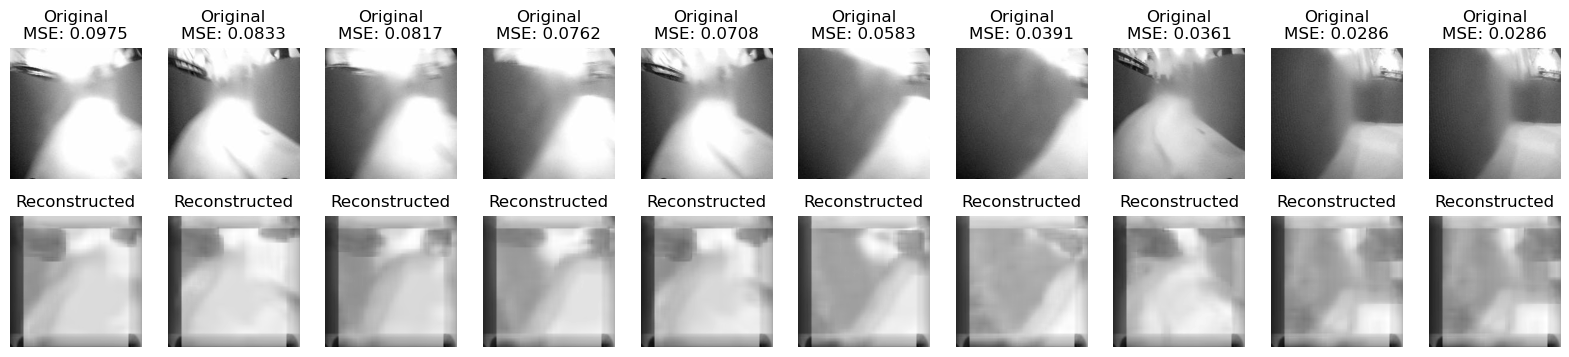

In [23]:
# Display sample images from the top 100 high MSE images
display_images(images, reconstructed_images, reconstruction_errors, top_100_indices, num_images=10)

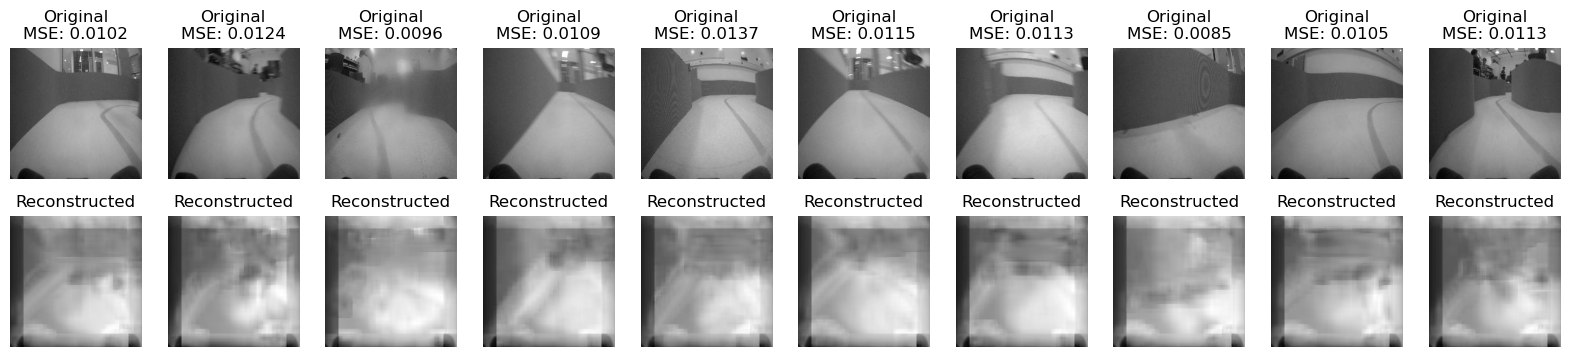

In [24]:
# Display sample images from random images
random_indices = np.random.choice(len(images), 10, replace=False)
display_images(images, reconstructed_images, reconstruction_errors, random_indices, num_images=10)